# Importing Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import time
from tensorflow.keras.callbacks import TensorBoard
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile 
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Downloading Dataset

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
!wget --no-check-certificate \
    "https://github.com/laxmimerit/dog-cat-full-dataset/archive/refs/heads/master.zip" \
    -O "/tmp/cats-and-dogs.zip"


zip_ref = zipfile.ZipFile('/tmp/cats-and-dogs.zip', 'r') # Opens the zip file in read mode
zip_ref.extractall('/tmp') # Extracts the files into the /tmp folder
zip_ref.close()


--2022-10-05 09:48:42--  https://github.com/laxmimerit/dog-cat-full-dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/laxmimerit/dog-cat-full-dataset/zip/refs/heads/master [following]
--2022-10-05 09:48:42--  https://codeload.github.com/laxmimerit/dog-cat-full-dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs.     [          <=>       ] 545.70M  17.4MB/s    in 33s     

2022-10-05 09:49:16 (16.7 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [572212372]



# Preparing the Dataset

In [4]:
# 5k test, 20k train images

PATH_TRAIN = "/tmp/dog-cat-full-dataset-master/data/train"
PATH_VALID = None
PATH_TEST = "/tmp/dog-cat-full-dataset-master/data/test"

In [5]:
image_size = (256, 256)
batch_size = 32

In [6]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode="nearest")

 
train_generator = train_datagen.flow_from_directory(directory=PATH_TRAIN,
                                                      batch_size=batch_size,
                                                      class_mode="binary",
                                                      target_size=image_size)

Found 20000 images belonging to 2 classes.


In [7]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
    PATH_TRAIN,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 20000 files belonging to 2 classes.
Using 6000 files for validation.


In [8]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    PATH_TEST,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=24,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 5000 files belonging to 2 classes.


In [9]:
test_ds.take(2)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

# Creating and Training the Model

In [11]:
number_of_color_channels = 3

IMG_SHAPE = list(image_size)
IMG_SHAPE.append(number_of_color_channels)
IMG_SHAPE = tuple(IMG_SHAPE)

print(IMG_SHAPE)

(256, 256, 3)


In [13]:
xtime = time.time()

#save model accuracy history graph by using tensorboard
#tensorboard = TensorBoard(log_dir=f"gdrive/MyDrive/.../DL-2 Cats and Dogs/Callbacks/tensorboard time={xtime}")

cat_dog_model = Sequential([
    keras.Input(IMG_SHAPE),
    tf.keras.layers.Rescaling(1./255)
])

cat_dog_model.add(Conv2D(64, (3,3), activation="relu"))
cat_dog_model.add(MaxPooling2D(pool_size=(2, 2)))
cat_dog_model.add(Dropout(0.33))

cat_dog_model.add(Conv2D(64, (3,3), activation="relu"))
cat_dog_model.add(MaxPooling2D(pool_size=(2, 2)))
cat_dog_model.add(Dropout(0.33))



cat_dog_model.add(Flatten())

cat_dog_model.add(Dense(64, activation="relu"))
cat_dog_model.add(Dropout(0.5))
cat_dog_model.add(Dense(1, activation="sigmoid")) # 2 classes,0 or 1, binary


cat_dog_model.compile(loss="binary_crossentropy",
                                  optimizer="Adam",
                                  metrics=["accuracy"])

cat_dog_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                    

In [16]:
history = cat_dog_model.fit(train_generator, epochs=20, validation_data=valid_ds) #callbacks=[tensorboard])

Epoch 1/20
625/625 [==============================] - 330s 528ms/step - loss: 0.6853 - accuracy: 0.5570 - val_loss: 0.6901 - val_accuracy: 0.5302
Epoch 2/20
625/625 [==============================] - 330s 527ms/step - loss: 0.6784 - accuracy: 0.5756 - val_loss: 0.6491 - val_accuracy: 0.6107
Epoch 3/20
625/625 [==============================] - 334s 535ms/step - loss: 0.6584 - accuracy: 0.6037 - val_loss: 0.6199 - val_accuracy: 0.6468
Epoch 4/20
625/625 [==============================] - 331s 530ms/step - loss: 0.6405 - accuracy: 0.6326 - val_loss: 0.5934 - val_accuracy: 0.6957
Epoch 5/20
625/625 [==============================] - 331s 529ms/step - loss: 0.6200 - accuracy: 0.6629 - val_loss: 0.5614 - val_accuracy: 0.7108
Epoch 6/20
625/625 [==============================] - 329s 527ms/step - loss: 0.5944 - accuracy: 0.6810 - val_loss: 0.5307 - val_accuracy: 0.7345
Epoch 7/20
625/625 [==============================] - 331s 529ms/step - loss: 0.5838 - accuracy: 0.6952 - val_loss: 0.5376 -

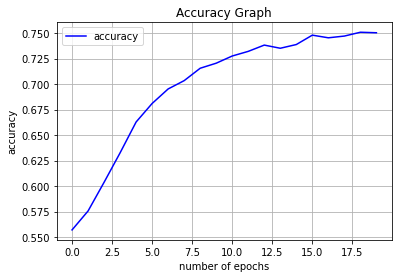

In [17]:
plt.plot(history.history["accuracy"],color="b",label="accuracy")
plt.title("Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

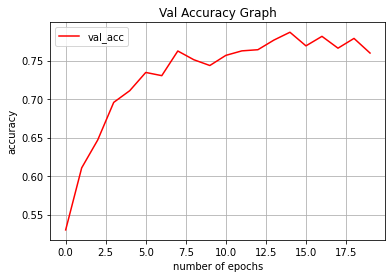

In [18]:
plt.plot(history.history["val_accuracy"],color="r",label="val_acc")
plt.title("Val Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

In [19]:
cat_dog_model.evaluate(test_ds)

157/157 [==============================] - 10s 59ms/step - loss: 0.4773 - accuracy: 0.7630


[0.4773332178592682, 0.7630000114440918]

# Further Training to Improve Accuracies

In [25]:
history2 = cat_dog_model.fit(train_generator, epochs=10, validation_data=valid_ds)

Epoch 1/10
625/625 [==============================] - 340s 543ms/step - loss: 0.5151 - accuracy: 0.7494 - val_loss: 0.4624 - val_accuracy: 0.7725
Epoch 2/10
625/625 [==============================] - 333s 533ms/step - loss: 0.5067 - accuracy: 0.7572 - val_loss: 0.4599 - val_accuracy: 0.7840
Epoch 3/10
625/625 [==============================] - 335s 536ms/step - loss: 0.5069 - accuracy: 0.7553 - val_loss: 0.4865 - val_accuracy: 0.7810
Epoch 4/10
625/625 [==============================] - 334s 534ms/step - loss: 0.5018 - accuracy: 0.7596 - val_loss: 0.4544 - val_accuracy: 0.7868
Epoch 5/10
625/625 [==============================] - 331s 530ms/step - loss: 0.5054 - accuracy: 0.7555 - val_loss: 0.4701 - val_accuracy: 0.7643
Epoch 6/10
625/625 [==============================] - 331s 529ms/step - loss: 0.4977 - accuracy: 0.7592 - val_loss: 0.4420 - val_accuracy: 0.7947
Epoch 7/10
625/625 [==============================] - 331s 529ms/step - loss: 0.4943 - accuracy: 0.7620 - val_loss: 0.4721 -

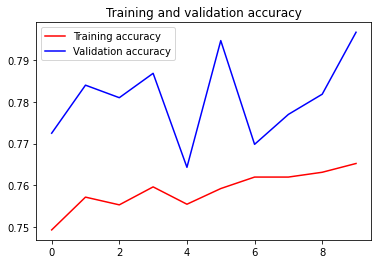

<Figure size 432x288 with 0 Axes>

In [26]:
# Plot the training and validation accuracies for each epoch

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [27]:
cat_dog_model.evaluate(test_ds)

157/157 [==============================] - 10s 60ms/step - loss: 0.4334 - accuracy: 0.7928


[0.43338343501091003, 0.7928000092506409]